In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sympy.physics.quantum.dagger import Dagger
import math
import random
import cmath
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct

#Functions

In [2]:
def Good_vectors(nq):
    sum_spin = math.ceil((nq) / 2 )
    good_vectors = basis.sum(dim = 1)
    good_vectors = (good_vectors == sum_spin).nonzero()[:,0]
    sub_batch = torch.zeros(good_vectors.shape[0], nq)
    i = torch.arange(0, good_vectors.shape[0], 1)
    sub_batch[i, :] = basis[good_vectors, :]
    good_batch = sub_batch
    a = 2**torch.arange(nq -1, -1,-1)
    num_batch = good_batch*a 
    num_batch = num_batch.sum(dim = 1)

    return good_vectors, good_batch, num_batch

In [3]:
def int10tobase_torch(num,base=2):
  c = num
  max_digit = nq-1
  res = torch.zeros((max_digit+1,num.shape[0]),dtype = torch.long)
  i = max_digit
  while(torch.sum(c)!=0):
    res[i,:] = torch.remainder(c,base)
    c = (c/base).type(torch.long)
    i-=1
  return res.t()

In [4]:
def permutations():
  main = torch.ones(nq)
  i = torch.arange(1,nq,2)
  main[i] = 0
  a = 2**torch.arange(nq -1, -1,-1)
  num_main = (main*a).sum()
  pm = torch.clone(main.reshape(1,nq).expand(nq-1,nq))
  for i in range(nq - 1):
    pm[i,i] = 1 - main[i]
    pm[i,i+1] = 1 - main[i+1]
  i = torch.arange(nq-1)
  res = torch.zeros(nq - 1, nq)
  ress = torch.zeros(nq - 1)
  res[i] = pm[i]*a 
  ress[i] = res[i].sum(dim = 1)
  batch = torch.cat((main.view(1,nq),pm), 0)
  ress = torch.cat((num_main.view(1),ress),0)
  t = ress.sort()
  i = torch.arange(nq)
  batch2 = torch.zeros(batch.shape[0], batch.shape[1])
  batch2[i,:] =  batch[t.indices[i],:]

  main[0] = 1
  main[nq-1] = 0
  batch2 = torch.cat((batch2, main.view(1,main.shape[0])), 0)
  last = (main*a).sum() 
  print(last)
  t = torch.cat((t.values.long().view(-1), last.view(-1)), 0)
  print(t) 
  return batch2, t

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
def sparce_m_OBC(batch, number_of_qubits, m):
    batch_new = torch.clone(batch).to(device)
    batch_size = batch.shape[0]
    batch_new[batch_new == 0] = -1

    row = torch.arange(0,batch.shape[0]).to(device)
    col = torch.arange(0,batch.shape[0]).to(device)
    data = torch.zeros(batch.shape[0]).to(device)
    
    t = torch.arange(0,number_of_qubits).to(device)
    batch_new[:,t] *= (-1)**(t)
    ##
    batch_new[:,t]  -= 1
    ##
    data[row] = -batch_new[row].sum(1)
    data *= m/2
    return data


def sparce_iter(batch, number_of_qubits):
    batch_size = batch.shape[0]
    batch_new = torch.clone(batch).to(device)
    batch_new[batch_new == 0] = -1
    row = torch.arange(0,batch.shape[0]).to(device)
    col = torch.arange(0,batch.shape[0]).to(device)
    
    
    data = torch.zeros(batch.shape[0]).to(device)
    
    coef_first = number_of_qubits - number_of_qubits % 2
    coef = torch.zeros(number_of_qubits ).to(device)
    for i in range(number_of_qubits -1):
        coef[i] = -coef_first
        if i%2 == 0 : 
            coef_first = coef_first-2       
    
    data[row] = (batch_new[row]*coef).sum(dim = 1)
    
    coef_2 = (torch.arange(number_of_qubits -2, 0, -1)*2)
    
    for i in range(0,number_of_qubits-1):
        s = torch.zeros(batch.shape[0]).to(device)
        for m in range(i+1, number_of_qubits-1):
            s += coef_2[m - 1]*batch_new[:,m]  
        data[row] += batch_new[row,i]*s[row]
       
    One = torch.eye(batch_size, batch_size).to(device)
    I = torch.tensor([range(0,number_of_qubits)]).sum()
    I += math.floor(number_of_qubits/2)
    One *= I 
    data += I
    return  data/4

In [7]:
def sparce_diag(nq, m, x, device, level):
    row = []
    col = []
    sum_spin = math.ceil((nq) / 2 - level)
    for i in range(nq - 1):
        ind = torch.tensor([i,i+1])
        good_batch_2 = torch.clone(good_batch).to(device)
        good_batch_2[:,ind] = 1 - good_batch_2[:,ind]
        r = (good_batch_2.sum(1) == sum_spin).nonzero().reshape(-1).to(device)
        a = 2**torch.arange(nq -1, -1,-1).to(device)
        out = good_batch_2[r]*a 
        out = out.sum(dim = 1).to(device)
        res = (out.unsqueeze(1) == num_batch).nonzero()
        col.append(r.cpu().numpy())
        row.append(res[:,1].cpu().numpy())
    row_xy = torch.tensor(row).reshape(-1).to(device)
    col_xy = torch.tensor(col).reshape(-1).to(device)
    data_xy = torch.ones(col_xy.shape[0]).to(device)

    row = torch.arange(0,good_batch.shape[0]).to(device)
    col = torch.arange(0,good_batch.shape[0]).to(device)
    good_batch.to(device)
    data = sparce_m_OBC(good_batch,nq, m) + sparce_iter(good_batch,nq)
    Row = torch.cat((row, row_xy), 0)
    Col = torch.cat((col, col_xy), 0)
    Data = torch.cat((data, data_xy*x), 0)
    
    eigenvalues, eigenvectors = eigsh(csr_matrix((Data.cpu(), (Row.cpu(), Col.cpu())), shape=(good_batch.shape[0], good_batch.shape[0])).astype(float), k=2, which = 'SA')
    return eigenvalues, eigenvectors

In [8]:
def sparce_diag_matrix(nq, m, x, device, level):
    row = []
    col = []
    sum_spin = math.ceil((nq) / 2 - level)
    for i in range(nq - 1):
        ind = torch.tensor([i,i+1])
        good_batch_2 = torch.clone(good_batch).to(device)
        good_batch_2[:,ind] = 1 - good_batch_2[:,ind]
        r = (good_batch_2.sum(1) == sum_spin).nonzero().reshape(-1).to(device)
        a = 2**torch.arange(nq -1, -1,-1).to(device)
        out = good_batch_2[r]*a 
        out = out.sum(dim = 1).to(device)
        res = (out.unsqueeze(1) == num_batch).nonzero()
        col.append(r.cpu().numpy())
        row.append(res[:,1].cpu().numpy())
    row_xy = torch.tensor(row).reshape(-1).to(device)
    col_xy = torch.tensor(col).reshape(-1).to(device)
    data_xy = torch.ones(col_xy.shape[0]).to(device)

    row = torch.arange(0,good_batch.shape[0]).to(device)
    col = torch.arange(0,good_batch.shape[0]).to(device)
    good_batch.to(device)
    data = sparce_m_OBC(good_batch,nq, m) + sparce_iter(good_batch,nq)
    Row = torch.cat((row, row_xy), 0)
    Col = torch.cat((col, col_xy), 0)
    Data = torch.cat((data, data_xy*x), 0)
    
    eigenvalues, eigenvectors = eigsh(csr_matrix((Data.cpu(), (Row.cpu(), Col.cpu())), shape=(good_batch.shape[0], good_batch.shape[0])).astype(float), k=2, which = 'SA')
    return eigenvalues, eigenvectors, Data, Row, Col

In [9]:
one = np.array([[1., 0.],[0.,1.]])
pauli_1 = np.array([[0.,1.],[1.,0.]])
pauli_2 = np.array([[0., 0-1j],[0 +1j, 0.]])
pauli_3 = np.array([[1.,0.],[0., -1.]])
plus = (1/2 * (pauli_1 + 1.j * pauli_2)).real
minus = (1/2 * (pauli_1 - 1.j * pauli_2)).real

In [10]:
def matrix_element_iter_new(batch):
    batch_size = batch.shape[0]
    batch_new = torch.clone(batch)
    batch_new[batch_new == 1] = -1
    batch_new[batch_new == 0] = 1
    C = torch.zeros(batch_size, batch_size).to(device)
    j = torch.arange(0,batch_size,1).to(device)
    
    coef_first = number_of_qubits - number_of_qubits % 2
    coef = torch.zeros(number_of_qubits ).to(device)
    
    for i in range(number_of_qubits -1):
        coef[i] = -coef_first
        if i%2 == 0 : 
            coef_first = coef_first-2       

    C[j,j] = -(batch_new[j]*coef).sum(dim = 1)
    coef_2 = (torch.arange(number_of_qubits -2, 0, -1)*2).to(device)
    
    for i in range(0,number_of_qubits-1):
        s = torch.zeros(batch_size).to(device)
        for m in range(i+1, number_of_qubits-1):
            s += coef_2[m - 1]*batch_new[:,m]  
        C[j,j] += batch_new[j,i]*s[j]
       
    One = torch.eye(batch_size, batch_size).to(device)
    I = torch.tensor([range(0,number_of_qubits)]).sum()
    I += math.floor(number_of_qubits/2)
    One *= I    
    return (C + One)/4
                

def matrix_element_m(batch):

    batch_new = torch.clone(batch)
    batch_size = batch.shape[0]
    batch_new[batch_new == 1] = -1
    batch_new[batch_new == 0] = 1
    
    t = torch.arange(0,number_of_qubits,1).to(device)
    
    batch_new[:,t] *= (-1)**(t+1)
    
    M = torch.zeros(batch_size, batch_size).to(device)
    j = torch.arange(0,batch_size,1)
    M[j,j] = -batch_new.sum(dim = 1)
    return m/2*M

def matrix_element_xy_new_7(batch):
    batch_new = torch.clone(batch)
    batch_size = batch.shape[0]
    batch_new[batch_new == 1] = -1
    batch_new[batch_new == 0] = 1
    res = batch_new.unsqueeze(1) != batch_new
    
    place = torch.zeros(number_of_qubits -1,number_of_qubits).to(device)
    C = torch.zeros(batch_size, batch_size).to(device)
    
    for i in range(number_of_qubits-1):
        place[i][i]= 1
        place[i][i+1] = 1
        true = torch.nonzero((res == place[i]).prod(dim = 2)==1)
        ress = batch_new[true[:,0],i]*batch_new[true[:,0],i+1]
        C[true[:,0], true[:,1]] = 1 - ress
    return C/2

def matrix(batch):               
    return  matrix_element_iter_new(batch) + matrix_element_xy_new_7(batch) + matrix_element_m(batch)

In [11]:
def Get_H_B(m,x, number_of_qubits):
    res_XY = torch.zeros(2**number_of_qubits, 2**number_of_qubits)
    res_mass = torch.zeros(2**number_of_qubits, 2**number_of_qubits)
    res_iter = torch.zeros(2**number_of_qubits, 2**number_of_qubits)


    # XY term
    first = one
    for i in range(1,number_of_qubits):
        first = one
        second = one
        for j in range(1, number_of_qubits -i-1):
            first = TensorProduct(one, first)
            second = TensorProduct(one, second)
        if i != number_of_qubits - 1 :
            first = TensorProduct(minus, first)
            first = TensorProduct(plus, first)
            second = TensorProduct(plus, second)
            second = TensorProduct(minus, second)
        else:
            first = TensorProduct(plus, minus)
            second = TensorProduct(minus, plus)
        for j in range(1,i):
            first = TensorProduct(one, first)
            second = TensorProduct(one, second)
        res_XY += torch.from_numpy(first + second)
    res_XY *= x

    # mass term
    for i in range(0, number_of_qubits ):
        mass = one
        one_one = one
        for j in range(0, number_of_qubits-2 - i):
            mass = TensorProduct(one, mass)
            one_one = TensorProduct(one, one_one)
        if i == (number_of_qubits - 1):
            mass = pauli_3
            one_one = one
        else:
            mass = TensorProduct(pauli_3, mass)
            one_one = TensorProduct(one, one_one)
        for j in range(0, i):
            mass = TensorProduct(one, mass)
            one_one = TensorProduct(one, one_one)
    
        res_mass += (-1)**i * (torch.from_numpy(mass)) + one_one


    # iteraction term
    for i in range(0,number_of_qubits -1):
        res_ite = torch.zeros(2**number_of_qubits , 2**number_of_qubits)
        res_ones = torch.zeros(2**number_of_qubits , 2**number_of_qubits)
        for j in range(0, i + 1):
        
            ite = one
        
            for k in range(0, number_of_qubits - j - 2):
                ite = TensorProduct(one, ite)
            if j == (number_of_qubits - 1):
                ite = pauli_3
            else:
                ite = TensorProduct(pauli_3, ite)
            for k in range(0, j):
                ite = TensorProduct(one, ite)
            res_ite += (torch.from_numpy(ite)) 
            ones = one
        
            for k in range(0,number_of_qubits-1):
                ones = TensorProduct(one, ones)
            res_ones += (-1)**j*(torch.from_numpy(ones))
        res_iter += torch.matmul(res_ones + res_ite, res_ones + res_ite)   
    
    
    return 1/4*res_iter + res_XY + m/2*res_mass 

In [ ]:
exact_x10_m25 = torch.tensor([ -58.0255,   -68.2646,   -78.5062,   -88.7489,   -98.9921,  -150.2091,
          -201.4265,  -252.6438,  -406.2958,  -508.7304,  -764.8170, -1020.9037,
         -1276.9903, -1563.8073])
exact_x10_m0 = torch.tensor([ -69.5819,   -81.7167,   -93.8621,  -106.0147,  -118.1724,  -178.9945,
          -239.8327,  -300.6731,  -483.1951,  -604.8765,  -909.0800, -1213.2834,
         -1517.4869, -1858.1948])
exact_x100_m25 = torch.tensor([ -711.2917,   -835.2465,   -959.2649,  -1083.3279,  -1207.4241,
          -1828.2040,  -2449.2478,  -3070.4105,  -4934.1245,  -6176.6444,
          -9282.9572, -12389.2713, -15495.5854, -18974.6573])
exact_x100_m0 = torch.tensor([-725.8484,   -852.1982,   -978.6049,  -1105.0506,  -1231.5242,
          -1864.1365,  -2496.9708,  -3129.9237,  -5029.0974,  -6295.3063,
          -9460.8839, -12626.4723, -15792.0613, -19337.5209])
exact_x1_m0 = torch.tensor([ -5.0478,   -5.9427,   -6.8375,   -7.7324,   -8.6273,  -13.1016,
          -17.5758,  -22.0501,  -35.4730,  -44.4216,  -66.7930,  -89.1645,
         -111.5359, -136.5919])
exact_x1_m01 = torch.tensor([   -4.7455,   -5.5886,   -6.4317,   -7.2749,   -8.1180,  -12.3335,
          -16.5491,  -20.7647,  -33.4113,  -41.8425,  -62.9203,  -83.9981,
         -105.0759, -128.6831])
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])

#X = 1


##x=1 m = 0

###9term

In [13]:
#m = 0, x = 1 nq = 18 
# Data from MPS
w001011 = 2.40158028993361e-05
w0011 = 0.00173099648456223
w01 = 0.1999
w10 = 0.6887
w100011 = 0.000806741804831
w1001 = 0.1068
w1010 = 0.4943
w10110 = 0.0861788455528179
w110 = 0.108890386753691
w11100 = 0.000748637218781378
n= np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100)

In [14]:
#Overlaps from data (norm of part, real and im parts)

a= torch.zeros(8)
a[0] = np.sqrt(0.797297640250068**2 +	0.60348964906497**2)*np.sqrt(0.199883829232202)
a[1] = np.sqrt(0.795822742139283**2 +0.602373270929322**2)*np.sqrt(0.688712449052086)
a[2] = np.sqrt(0.410920829688335**2+	0.911619217793715**2)*np.sqrt(0.00173104391998192)
a[3] = np.sqrt(0.439205740956884**2+	0.898100525004861**2)*np.sqrt(0.108889412613798)
a[4] = np.sqrt(0.762921793824329**2+	0.640201103654071**2)*np.sqrt(0.798363361188297)
a[5] = np.sqrt(0.393625273035252**2 + 0.919207491601952**2)*np.sqrt(0.19988120851635)
a[6] = np.sqrt(0.877820444974296**2 +0.478868008366455**2)*np.sqrt(0.199887133464269)
a[7] = np.sqrt(0.888834989165014**2 +0.449310399188158**2)*np.sqrt(0.798356965013178)
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[2],a[0]])

In [15]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)
ol[12] = ol[12]*np.sqrt(w001011*w01)
ol[13] = ol[13]*np.sqrt(w001011*w0011)

In [16]:
# Calculate 6 Energies [13:18]
start = 18
E = []
x_param = 1
m = 0
for nq in np.arange(start -6,start,1):
  x = torch.arange(2**nq)
  basis = int10tobase_torch(x).type(torch.float32)
  good_vectors, good_batch, num_batch = Good_vectors(nq)
  num_batch = num_batch.to(device)
  eigenvalues, eigenvectors, Data, Row, Col = sparce_diag_matrix(nq,m,x_param,device,0)
  E.append(eigenvalues[0])

start = 18
for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - (start)] +5 +2*m) + w0011*(E[nq - (start-2)] +3 + 2*m) + w01*( E[nq - (start- 4)] + 1 +2*m) + w100011*( E[nq - (start)] +3 +2*m) + w1001*( E[nq - (start-2)]+1 +2*m ) + w1010*( E[nq - (start-2)]) + w10110*( E[nq - (start-1)]+1+2*m ) + w110*(E[nq - (start-3)] + 1 +2*m)+ w11100*(E[nq - (start-1)]+ 3 +2*m) )/n**2 + 2*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  #print(E_)
  E.append(E_)

<ipython-input-8-52ab03d6bbff>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  row_xy = torch.tensor(row).reshape(-1).to(device)


In [17]:
np.savetxt('E9_x1_m0.txt',E)
E9_x1_m0 = np.loadtxt('E9_x1_m0.txt') 

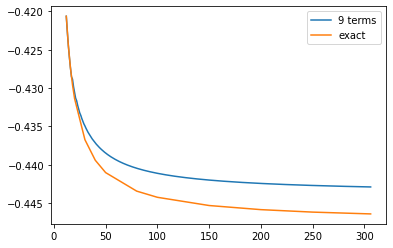

In [18]:
N = np.arange(start-6,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(N,E9_x1_m0/N, label = '9 terms')
plt.plot(x,exact_x1_m0/x, label = 'exact')
plt.legend()

###11term

In [19]:
#m = 0, x = 1 nq = 18
# Data from MPS
w001011 = 2.40158028993361e-05
w0011 = 0.00173099648456223
w01 = 0.1999
w10 = 0.6887
w10001011 = 1.08765565163471e-05
w100011 = 0.000806741804831
w1001 = 0.1068
w1010 = 0.4943
w10110 = 0.0861788455528179
w1011100 = 0.000629186767500283
w110 = 0.108890386753691
w11100 = 0.000748637218781378
n= np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100 + w10001011 + w1011100)

In [20]:
a= torch.zeros(14)
a[0] = np.sqrt(0.797297640250068**2 +	0.60348964906497**2)*np.sqrt(0.199883829232202)
a[1] = np.sqrt(0.795822742139283**2 +0.602373270929322**2)*np.sqrt(0.688712449052086)
a[2] = np.sqrt(0.410920829688335**2+	0.911619217793715**2)*np.sqrt(0.00173104391998192)
a[3] = np.sqrt(0.439205740956884**2+	0.898100525004861**2)*np.sqrt(0.108889412613798)
a[4] = np.sqrt(0.762921793824329**2+	0.640201103654071**2)*np.sqrt(0.798363361188297)

a[5] = np.sqrt(0.393625273035252**2 + 0.919207491601952**2)*np.sqrt(0.19988120851635)
a[6] = np.sqrt(0.877820444974296**2 +0.478868008366455**2)*np.sqrt(0.199887133464269)
a[7] = np.sqrt(0.888834989165014**2 +0.449310399188158**2)*np.sqrt(0.798356965013178)


a[8] = torch.clone(a[0])
a[9] = torch.clone(a[2])
a[10] = torch.clone(a[1])
a[11] = torch.clone(torch.tensor(np.sqrt(w001011)))
a[12] = torch.clone(torch.tensor(np.sqrt(w11100)))
a[13] = torch.clone(a[2])
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[8],a[9],a[10],a[11],a[12],a[13],a[2],a[0]])
#ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5]])

In [21]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)

ol[12] = ol[12]*np.sqrt(w10001011*w100011)
ol[13] = ol[13]*np.sqrt(w10001011*w1001)
ol[14] = ol[14]*np.sqrt(w10110*w1011100)
ol[15] = ol[15]*np.sqrt(w01*w10001011)
ol[16] = ol[16]*np.sqrt(w01*w1011100)
ol[17] = ol[17]*np.sqrt(w1011100*w110)


ol[18] = ol[18]*np.sqrt(w001011*w01)
ol[19] = ol[19]*np.sqrt(w001011*w0011)

In [22]:
start = 18
E = []
x_param = 1
m = 0
for nq in np.arange(start -8,start,1):
  x = torch.arange(2**nq)
  basis = int10tobase_torch(x).type(torch.float32)
  good_vectors, good_batch, num_batch = Good_vectors(nq)
  num_batch = num_batch.to(device)
  eigenvalues, eigenvectors, Data, Row, Col = sparce_diag_matrix(nq,m,x_param,device,0)
  E.append(eigenvalues[0])

start = 18
for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - start + 2] +5 +2*m) + w0011*(E[nq - start + 4] +3 + 2*m) + w01*( E[nq - (start- 6)] + 1 +2*m) + w100011*( E[nq - (start-2)] +3 +2*m) + w1001*( E[nq - (start-4)]+1 +2*m ) + w1010*( E[nq - (start-4)]) + w10110*( E[nq - (start-3)]+1+2*m ) + w110*(E[nq - (start-5)] + 1 +2*m)+ w11100*(E[nq - (start-3)]+ 3 +2*m)  + w1011100*(E[nq-start+1] + 3 + 2*m) + w10001011*(E[nq-start]+ 5 + 2*m))/n**2 + 2*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  #print(E_)
  E.append(E_)

In [23]:
np.savetxt('E11_x1_m0.txt',E)
E11_x1_m0 = np.loadtxt('E11_x1_m0.txt') 

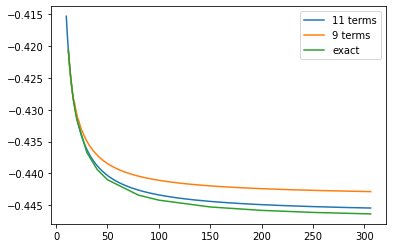

In [24]:
N = np.arange(start-8,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(N,E11_x1_m0/N, label = '11 terms')
N = np.arange(start-6,307,1)
plt.plot(N,E9_x1_m0/N, label = '9 terms')
plt.plot(x,exact_x1_m0/x, label = 'exact')
plt.legend()

##x=1 m = 0.1

###9term

In [25]:
#m = 0.1, x = 1 nq = 18 
#Data from MPS
w001011 = 1.59355797842985e-05
w0011 = 0.00130904277010119	
w01 = 0.177514058821735
w10 = 0.716742333483117
w100011 = 0.000649067094064316
w1001 = 0.100292609553167
w1010 = 0.531818137346089
w10110 = 0.083441940415131
w110 = 0.103788600551844
w11100 = 0.00062230028445723
n= np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100)

In [26]:
a= torch.zeros(8)
a[0] = np.sqrt(0.177514219188592)*np.sqrt(0.93430199411195**2+	0.356366038767037**2)
a[1] = np.sqrt(0.71674244408866)*np.sqrt(0.932996655878117**2+0.355868150731248**2)
a[2] = np.sqrt(0.00130905448867319)*np.sqrt(0.12104582983895**2+0.992607188055437**2)
a[3] = np.sqrt(0.103788331731205)*np.sqrt(0.306911040686105**2+0.951571582333403**2)
a[4] = np.sqrt(0.821161161526126)*np.sqrt(0.353246550466207**2+0.932543833364208**2)
a[5] = np.sqrt(0.177513553899011)*np.sqrt(0.915283155294413**2+0.402707973750892**2)
a[6] = np.sqrt(0.17751519883097)*np.sqrt(0.240647623233458**2+0.970569779070271**2)
a[7] = np.sqrt(0.821159385667823)*np.sqrt(0.0522243908535814**2+	0.995838259724563**2)
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5]])

In [27]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)

In [28]:
start = 18
E = []
x_param = 1
m = 0.1
for nq in np.arange(start -6,start,1):
  x = torch.arange(2**nq)
  basis = int10tobase_torch(x).type(torch.float32)
  good_vectors, good_batch, num_batch = Good_vectors(nq)
  num_batch = num_batch.to(device)
  eigenvalues, eigenvectors, Data, Row, Col = sparce_diag_matrix(nq,m,x_param,device,0)
  E.append(eigenvalues[0])

start = 18
for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - (start)] +5 +2*m) + w0011*(E[nq - (start-2)] +3 + 2*m) + w01*( E[nq - (start- 4)] + 1 +2*m) + w100011*( E[nq - (start)] +3 +2*m) + w1001*( E[nq - (start-2)]+1 +2*m ) + w1010*( E[nq - (start-2)]) + w10110*( E[nq - (start-1)]+1+2*m ) + w110*(E[nq - (start-3)] + 1 +2*m)+ w11100*(E[nq - (start-1)]+ 3 +2*m) )/n**2 + 2*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  E.append(E_)


In [29]:
np.savetxt('E9_x1_m01.txt',E)
E9_x1_m01 = np.loadtxt('E9_x1_m01.txt') 

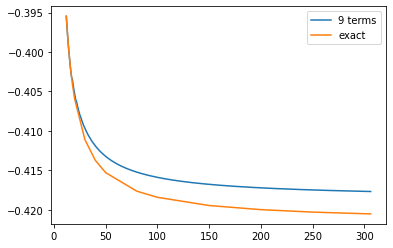

In [30]:
N = np.arange(start-6,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(N,E9_x1_m01/N, label = '9 terms')
plt.plot(x,exact_x1_m01/x, label = 'exact')
plt.legend()


###11term

In [31]:
#m = 0.1, x = 1 nq = 18 
# Data from MPS
w001011 = 1.59355797842985e-05
w0011 = 0.00130904277010119	
w01 = 0.177514058821735
w10 = 0.716742333483117
w10001011 = 7.68632746981713e-06
w100011 = 0.000649067094064316
w1001 = 0.100292609553167
w1010 = 0.531818137346089
w10110 = 0.083441940415131
w1011100 = 0.000526406778244713
w110 = 0.103788600551844
w11100 = 0.00062230028445723
n= np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100+ w10001011 + w1011100)

In [32]:
a= torch.zeros(14)
a[0] = np.sqrt(0.177514219188592)*np.sqrt(0.93430199411195**2+	0.356366038767037**2)
a[1] = np.sqrt(0.71674244408866)*np.sqrt(0.932996655878117**2+0.355868150731248**2)
a[2] = np.sqrt(0.00130905448867319)*np.sqrt(0.12104582983895**2+0.992607188055437**2)
a[3] = np.sqrt(0.103788331731205)*np.sqrt(0.306911040686105**2+0.951571582333403**2)
a[4] = np.sqrt(0.821161161526126)*np.sqrt(0.353246550466207**2+0.932543833364208**2)
a[5] = np.sqrt(0.177513553899011)*np.sqrt(0.915283155294413**2+0.402707973750892**2)
a[6] = np.sqrt(0.17751519883097)*np.sqrt(0.240647623233458**2+0.970569779070271**2)
a[7] = np.sqrt(0.821159385667823)*np.sqrt(0.0522243908535814**2+	0.995838259724563**2)
#ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5]])

a[8] = torch.clone(a[0])
a[9] = torch.clone(a[2])
a[10] = torch.clone(a[1])
a[11] = torch.clone(torch.tensor(np.sqrt(w001011)))
a[12] = torch.clone(torch.tensor(np.sqrt(w11100)))
a[13] = torch.clone(a[2])
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[8],a[9],a[10],a[11],a[12],a[13]])
#ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5]])

In [33]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)

ol[12] = ol[12]*np.sqrt(w10001011*w100011)
ol[13] = ol[13]*np.sqrt(w10001011*w1001)
ol[14] = ol[14]*np.sqrt(w10110*w1011100)
ol[15] = ol[15]*np.sqrt(w01*w10001011)
ol[16] = ol[16]*np.sqrt(w01*w1011100)
ol[17] = ol[17]*np.sqrt(w1011100*w110)

In [34]:
start = 18
E = []
x_param = 1
m = 0.1
for nq in np.arange(start -8,start,1):
  x = torch.arange(2**nq)
  basis = int10tobase_torch(x).type(torch.float32)
  good_vectors, good_batch, num_batch = Good_vectors(nq)
  num_batch = num_batch.to(device)
  eigenvalues, eigenvectors, Data, Row, Col = sparce_diag_matrix(nq,m,x_param,device,0)
  E.append(eigenvalues[0])

for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - start + 2] +5 +2*m) + w0011*(E[nq - start + 4] +3 + 2*m) + w01*( E[nq - (start- 6)] + 1 +2*m) + w100011*( E[nq - (start-2)] +3 +2*m) + w1001*( E[nq - (start-4)]+1 +2*m ) + w1010*( E[nq - (start-4)]) + w10110*( E[nq - (start-3)]+1+2*m ) + w110*(E[nq - (start-5)] + 1 +2*m)+ w11100*(E[nq - (start-3)]+ 3 +2*m)  + w1011100*(E[nq-start+1] + 3 + 2*m) + w10001011*(E[nq-start]+ 5 + 2*m))/n**2 + 2*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  E.append(E_)

In [35]:
np.savetxt('E11_x1_m01.txt',E)
E11_x1_m01 = np.loadtxt('E11_x1_m01.txt') 

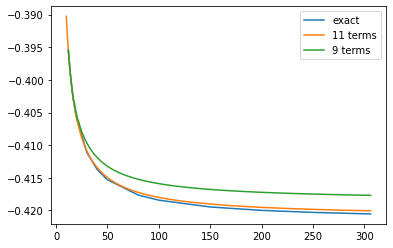

In [36]:
N = np.arange(start-8,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(x, exact_x1_m01/x, label = 'exact')
plt.plot(N, E11_x1_m01/N, label = '11 terms')
N = np.arange(start-6,307,1)
plt.plot(N, E9_x1_m01/N, label = '9 terms')
plt.legend()

# X = 10

##x=10,m = 0

###9term

In [37]:
#m = 0, x = 10 Data from MPS
w001011 = 0.00332287062162417
w0011 = 0.0244476841688653
w01 = 0.373998880184215
w10 = 0.494213317427489
w100011 = 0.0083948614091022
w1001 = 0.143504503359102
w1010 = 0.267143715594907
w10110 = 0.0705462716567287
w110 = 0.0995560601794406
w11100 = 0.00313846590350794	
n = np.sqrt(w001011+w0011+w01+w100011+w1010+w1001+w10110+w110+w11100)


In [38]:
a= torch.zeros(8)
a[0] = np.sqrt(0.373998886081244)*np.sqrt(0.759784605665817	**2+0.649011683644611**2)
a[1] = np.sqrt(0.494213314988611)*np.sqrt(0.755515948009182**2+	0.645365375648219**2)
a[2] = np.sqrt(0.0244476857896228)*np.sqrt(0.858108911194066**2+0.504773963685414**2)
a[3] = np.sqrt(0.0995560548561682)*np.sqrt(0.831828925068136**2+0.537393924197203**2)
a[4] = np.sqrt(0.597281694072945)*np.sqrt(0.765630908129325**2+	0.555828443845095**2)
a[5] = np.sqrt(0.373998846492657)*np.sqrt(0.879492360858329**2+	0.474322675721981**2)
a[6] = np.sqrt(0.373998894864949)*np.sqrt(0.325819077334707**2+	0.944632595847381**2)
a[7] = np.sqrt(0.597281626245684)*np.sqrt(0.937717367911943**2+	0.125785847867006**2)
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[2],a[0]])

In [39]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)

ol[12] = ol[12]*np.sqrt(w001011*w01)
ol[13] = ol[13]*np.sqrt(w001011*w0011)

In [40]:
nq = 74
m = 0
E = []
for nq in np.arange(74,80):
  H_r = torch.zeros(4,4)
  H_r[0,0] = -6.082*nq + 26.49
  H_r[1,1] = -6.084*nq + 16.65
  H_r[2,2] = -6.084*nq + 15.75 
  H_r[3,3] = -6.086*nq + 21.49
  H_r[0,1] =  -6.512
  H_r[1,0] =  -6.512
  H_r[2,1] = -9.909
  H_r[1,2] = -9.909
  H_r[2,3] = -8.088
  H_r[3,2] = -8.088
  values, vectors = np.linalg.eig(H_r)
  R1 = vectors[:,0].reshape(-1)
  E.append(values[0])

start = 80
for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - (start)] +5 +2*m) + w0011*(E[nq - (start-2)] +3 + 2*m) + w01*( E[nq - (start- 4)] + 1 +2*m) + w100011*( E[nq - (start)] +3 +2*m) + w1001*( E[nq - (start-2)]+1 +2*m ) + w1010*( E[nq - (start-2)]) + w10110*( E[nq - (start-1)]+1+2*m ) + w110*(E[nq - (start-3)] + 1 +2*m)+ w11100*(E[nq - (start-1)]+ 3 +2*m) )/n**2 + 20*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  #print(E_)
  E.append(E_)

In [41]:
np.savetxt('E9_x10_m0.txt',E)
E9_x10_m0 = np.loadtxt('E9_x10_m0.txt')

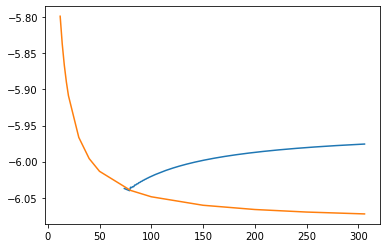

In [42]:
N = np.arange(start-6,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(N,E9_x10_m0/N, label = 'converged weights')
plt.plot(x, exact_x10_m0/x, label = 'exact')

###11term

In [43]:
#m = 0, x = 10 Data from MPS
w001011 = 0.00332287062162417
w0011 = 0.0244476841688653
w01 = 0.373998880184215
w10 = 0.494213317427489
w10001011 = 0.00111655739904886
w100011 = 0.0083948614091022
w1001 = 0.143504503359102
w1010 = 0.267143715594907
w10110 = 0.0705462716567287
w1011100 = 0.00281055530592409
w110 = 0.0995560601794406
w11100 = 0.00313846590350794	
n = np.sqrt(w001011+w0011+w01+w100011+w1010+w1001+w10110+w110+w11100)
n = np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100 + w10001011 + w1011100)
print(n)

0.9989897025407549


In [44]:
a= torch.zeros(16)
a[0] = np.sqrt(0.373998886081244)*np.sqrt(0.759784605665817	**2+0.649011683644611**2)
a[1] = np.sqrt(0.494213314988611)*np.sqrt(0.755515948009182**2+	0.645365375648219**2)
a[2] = np.sqrt(0.0244476857896228)*np.sqrt(0.858108911194066**2+0.504773963685414**2)
a[3] = np.sqrt(0.0995560548561682)*np.sqrt(0.831828925068136**2+0.537393924197203**2)
a[4] = np.sqrt(0.597281694072945)*np.sqrt(0.765630908129325**2+	0.555828443845095**2)
a[5] = np.sqrt(0.373998846492657)*np.sqrt(0.879492360858329**2+	0.474322675721981**2)
a[6] = np.sqrt(0.373998894864949)*np.sqrt(0.325819077334707**2+	0.944632595847381**2)
a[7] = np.sqrt(0.597281626245684)*np.sqrt(0.937717367911943**2+	0.125785847867006**2)


a[8] = torch.clone(a[0])
a[9] = torch.clone(a[2])
a[10] = torch.clone(a[1])
a[11]  = np.sqrt(0.00332287110118853)*np.sqrt(0.262819832121407**2+0.95814022065026**2)#= torch.clone(torch.tensor(np.sqrt(w001011)))
a[12] = np.sqrt(0.00313846549670361)*np.sqrt(0.978665228500561**2+	0.195272344411112**2)#= torch.clone(torch.tensor(np.sqrt(w11100))) 
a[13] = torch.clone(a[2])

a[14] = torch.clone(a[2])
a[15] = torch.clone(a[0])
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[8],a[9],a[10],a[11],a[12],a[13],a[14],a[15]])
#ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5]])

In [45]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)


ol[12] = ol[12]*np.sqrt(w10001011*w100011)
ol[13] = ol[13]*np.sqrt(w10001011*w1001)
ol[14] = ol[14]*np.sqrt(w10110*w1011100)
ol[15] = ol[15]*np.sqrt(w01*w10001011)
ol[16] = ol[16]*np.sqrt(w01*w1011100)
ol[17] = ol[17]*np.sqrt(w1011100*w110)

ol[18] = ol[18]*np.sqrt(w001011*w01)
ol[19] =ol[19]*np.sqrt(w001011*w0011)

In [46]:
nq = 72
m = 0
E = []
for nq in np.arange(72,80):
  H_r = torch.zeros(4,4)
  H_r[0,0] = -6.082*nq + 26.49
  H_r[1,1] = -6.084*nq + 16.65
  H_r[2,2] = -6.084*nq + 15.75 
  H_r[3,3] = -6.086*nq + 21.49
  H_r[0,1] =  -6.512
  H_r[1,0] =  -6.512
  H_r[2,1] = -9.909
  H_r[1,2] = -9.909
  H_r[2,3] = -8.088
  H_r[3,2] = -8.088
  values, vectors = np.linalg.eig(H_r)
  R1 = vectors[:,0].reshape(-1)
  E.append(values[0])

start = 80
for nq in np.arange(80,307,1):
  E_ = (w001011*( E[nq - start + 2] +5 +2*m) + w0011*(E[nq - start + 4] +3 + 2*m) + w01*( E[nq - (start- 6)] + 1 +2*m) + w100011*( E[nq - (start-2)] +3 +2*m) + w1001*( E[nq - (start-4)]+1 +2*m ) + w1010*( E[nq - (start-4)]) + w10110*( E[nq - (start-3)]+1+2*m ) + w110*(E[nq - (start-5)] + 1 +2*m)+ w11100*(E[nq - (start-3)]+ 3 +2*m)  + w1011100*(E[nq-start+1] + 3 + 2*m) + w10001011*(E[nq-start]+ 5 + 2*m))/n**2 + 20*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  #print(E_)
  E.append(E_)

In [47]:
np.savetxt('E11_x10_m0.txt',E)
E11_x10_m0 = np.loadtxt('E11_x10_m0.txt')

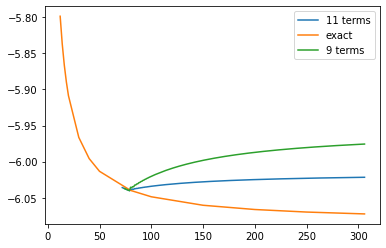

In [48]:
N = np.arange(start-8,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(N,E11_x10_m0/N, label = '11 terms')
plt.plot(x, exact_x10_m0/x, label = 'exact')
N = np.arange(start-6,307,1)
plt.plot(N, E9_x10_m0/N, label = '9 terms')
plt.legend()

##x=10, m = 2.5

###9term

In [49]:
#m = 2.5, x = 10 Data from MPS
w001011 = 0.000919438840879987
w0011 = 0.0100947724505279
w01 = 0.263108384194142
w10 = 0.609799860127001
w100011 = 	0.00399395422465334
w1001 = 0.122781616289503
w1010 = 0.394061775587907
w10110 = 0.0859531994401827
w110 = 0.113007718768893
w11100 = 0.0026656998724599		
n = np.sqrt(w001011+w0011+w01+w100011+w1010+w1001+w10110+w110+w11100)
n = np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100)
print(n)

0.9982918208966499


In [50]:
a= torch.zeros(8)
a[0] = np.sqrt(0.263108384187412)*np.sqrt(0.787710139058015**2+	0.615730866060968**2)
a[1] = np.sqrt(0.609799860109403)*np.sqrt(0.785093234178949**2+	0.613685305119888**2)
a[2] = np.sqrt(0.0100947724489662)*np.sqrt(0.533236467911787**2+0.84328356420035**2)
a[3] = np.sqrt(0.113007718792398)*np.sqrt(0.126310164375767**2+0.991156521226541**2)
a[4] = np.sqrt(0.725701089347914)*np.sqrt(0.550781913106866**2+0.819802106652408**2)
a[5] = np.sqrt(0.263108384181216)*np.sqrt(0.980145905869626**2+0.197296137327964**2)
a[6] = np.sqrt(0.26310838416753)*np.sqrt(0.099425486037954**2+0.994849905927476**2)
a[7] = np.sqrt(0.725701089367933)*np.sqrt(0.701726657641771**2+	0.694993458832397	**2)
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5], a[2],a[0]])
print(ol)

tensor([0.5128, 0.1002, 0.5128, 0.7782, 0.3359, 0.5128, 0.8414, 0.8414, 0.5128,
        0.5128, 0.1002, 0.5128, 0.1002, 0.5128])


In [51]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)

ol[12] = ol[12]*np.sqrt(w001011*w01)
ol[13] = ol[13]*np.sqrt(w001011*w0011)

In [52]:
nq = 74
m = 2.5
E = []
for nq in np.arange(74,80):
  H_r = torch.zeros(4,4)
  H_r[0,0] = -5.121*nq + 29.1
  H_r[1,1] = -5.122*nq + 19.68
  H_r[2,2] = -5.122*nq + 13.78 
  H_r[3,3] = -5.122*nq + 23.56
  H_r[0,1] =  -5.316
  H_r[1,0] =  -5.316
  H_r[2,1] = -9.955
  H_r[1,2] = -9.955
  H_r[2,3] = -8.752
  H_r[3,2] = -8.752
  values, vectors = np.linalg.eig(H_r)
  R1 = vectors[:,0].reshape(-1)
  E.append(values[0])

start = 80
for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - (start)] +5 +2*m) + w0011*(E[nq - (start-2)] +3 + 2*m) + w01*( E[nq - (start- 4)] + 1 +2*m) + w100011*( E[nq - (start)] +3 +2*m) + w1001*( E[nq - (start-2)]+1 +2*m ) + w1010*( E[nq - (start-2)]) + w10110*( E[nq - (start-1)]+1+2*m ) + w110*(E[nq - (start-3)] + 1 +2*m)+ w11100*(E[nq - (start-1)]+ 3 +2*m) )/n**2 + 20*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  #print(E_)
  E.append(E_)

In [53]:
np.savetxt('E9_x10_m25.txt',E)
E9_x10_m25 = np.loadtxt('E9_x10_m25.txt')

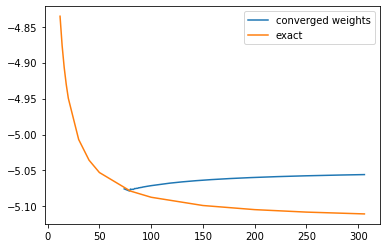

In [54]:
N = np.arange(74,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(N,E9_x10_m25/N, label = 'converged weights')
plt.plot(x, exact_x10_m25/x, label = 'exact')
plt.legend()

###11term

In [55]:
#m = 2.5, x = 10 Data from MPS
w001011 = 0.000919438840879987
w0011 = 0.0100947724505279
w01 = 0.263108384194142
w10 = 0.609799860127001
w10001011 = 0.000346788879301937
w100011 = 	0.00399395422465334
w1001 = 0.122781616289503
w1010 = 0.394061775587907
w10110 = 0.0859531994401827
w1011100 = 0.00237632985853286
w110 = 0.113007718768893
w11100 = 0.0026656998724599		
n = np.sqrt(w001011+w0011+w01+w100011+w1010+w1001+w10110+w110+w11100)
n = np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100 + w10001011 + w1011100)
print(n)

0.9996547796149348


In [56]:
a= torch.zeros(16)
a[0] = np.sqrt(0.263108384187412)*np.sqrt(0.787710139058015**2+	0.615730866060968**2)
a[1] = np.sqrt(0.609799860109403)*np.sqrt(0.785093234178949**2+	0.613685305119888**2)
a[2] = np.sqrt(0.0100947724489662)*np.sqrt(0.533236467911787**2+0.84328356420035**2)
a[3] = np.sqrt(0.113007718792398)*np.sqrt(0.126310164375767**2+0.991156521226541**2)
a[4] = np.sqrt(0.725701089347914)*np.sqrt(0.550781913106866**2+0.819802106652408**2)
a[5] = np.sqrt(0.263108384181216)*np.sqrt(0.980145905869626**2+0.197296137327964**2)
a[6] = np.sqrt(0.26310838416753)*np.sqrt(0.099425486037954**2+0.994849905927476**2)
a[7] = np.sqrt(0.725701089367933)*np.sqrt(0.701726657641771**2+	0.694993458832397	**2)


a[8] = torch.clone(a[0])
a[9] = torch.clone(a[2])
a[10] = torch.clone(a[1])
a[11] = np.sqrt(0.000919438841022223)*np.sqrt(0.29672139802051**2	+0.951073243633276**2) #= torch.clone(torch.tensor(np.sqrt(w001011)))
a[12] = np.sqrt(0.00266569987407459)*np.sqrt(0.103310069356209**2	+0.993557208117968**2) # = torch.clone(torch.tensor(np.sqrt(w11100)))
a[13] = torch.clone(a[2])

a[14] = torch.clone(a[2])
a[15] = torch.clone(a[0])
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[8],a[9],a[10],a[11],a[12],a[13],a[14],a[15]])


In [57]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)

ol[12] = ol[12]*np.sqrt(w10001011*w100011)
ol[13] = ol[13]*np.sqrt(w10001011*w1001)
ol[14] = ol[14]*np.sqrt(w10110*w1011100)
ol[15] = ol[15]*np.sqrt(w01*w10001011)
ol[16] = ol[16]*np.sqrt(w01*w1011100)
ol[17] = ol[17]*np.sqrt(w1011100*w110)

ol[18] = ol[18]*np.sqrt(w001011*w01)
ol[19] =ol[19]*np.sqrt(w001011*w0011)

In [58]:
nq = 72
m = 2.5
E = []
for nq in np.arange(72,80):
  H_r = torch.zeros(4,4)
  H_r[0,0] = -5.121*nq + 29.1
  H_r[1,1] = -5.122*nq + 19.68
  H_r[2,2] = -5.122*nq + 13.78 
  H_r[3,3] = -5.122*nq + 23.56
  H_r[0,1] =  -5.316
  H_r[1,0] =  -5.316
  H_r[2,1] = -9.955
  H_r[1,2] = -9.955
  H_r[2,3] = -8.752
  H_r[3,2] = -8.752
  values, vectors = np.linalg.eig(H_r)
  R1 = vectors[:,0].reshape(-1)
  E.append(values[0])

start = 80
for nq in np.arange(80,307,1):
  E_ = (w001011*( E[nq - start + 2] +5 +2*m) + w0011*(E[nq - start + 4] +3 + 2*m) + w01*( E[nq - (start- 6)] + 1 +2*m) + w100011*( E[nq - (start-2)] +3 +2*m) + w1001*( E[nq - (start-4)]+1 +2*m ) + w1010*( E[nq - (start-4)]) + w10110*( E[nq - (start-3)]+1+2*m ) + w110*(E[nq - (start-5)] + 1 +2*m)+ w11100*(E[nq - (start-3)]+ 3 +2*m)  + w1011100*(E[nq-start+1] + 3 + 2*m) + w10001011*(E[nq-start]+ 5 + 2*m))/n**2 + 20*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  E.append(E_)

In [59]:
np.savetxt('E11_x10_m25.txt',E)
E11_x10_m25 = np.loadtxt('E11_x10_m25.txt')

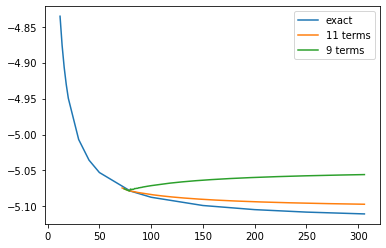

In [60]:
N = np.arange(start-8,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(x, exact_x10_m25/x, label = 'exact')
plt.plot(N,E11_x10_m25/N, label = '11 terms')
N = np.arange(start-6,307,1)
plt.plot(N,E9_x10_m25/N, label = '9 terms')
plt.legend()

#X = 100

##x = 100 m=0

### 9 term

In [61]:
#m = 0, x = 100 Data from MPS

w001011 = 0.0088909404618675
w0011 = 0.0402435396148426
w01 = 0.415377161953834
w10 = 0.447126060915845
w100011 = 0.0142051984348521
w1001 = 0.151858299610668
w1010 = 0.219958993092895
w10110 = 0.0526053571953399
w110 = 0.0791951282297465
w11100 = 0.00278473729142628
n = np.sqrt(w001011+w0011+w01+w100011+w1010+w1001+w10110+w110+w11100)


In [62]:
a= torch.zeros(8)
a[0] = np.sqrt(0.415388283972123)*np.sqrt(0.995304309795281**2	+0.0655118343657348**2)
a[1] = np.sqrt(0.447117693151699)*np.sqrt(0.991989652826353**2+	0.0652936606335732**2)
a[2] = np.sqrt(0.040247740846978)*np.sqrt(0.798085723689355**2 +	0.579642127523834**2)
a[3] = np.sqrt(0.0791851098619123)*np.sqrt(0.832499959069733**2	-0.438321017182823**2)
a[4] = np.sqrt(0.529937468823771)*np.sqrt(0.177079053942673**2 +	0.833025150964529**2)
a[5] = np.sqrt(0.415180104299204)*np.sqrt(0.687043825799479**2+	0.723131010084857**2)
a[6] = np.sqrt(0.415400781720677)*np.sqrt(0.766815850380277**2 + 0.637898431397149**2)
a[7] = np.sqrt(0.529553724140784)*np.sqrt(0.725822103954878**2 + 0.44536239129891**2)
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[2],a[0]])

In [63]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)

ol[12] = ol[12]*np.sqrt(w001011*w01)
ol[13] = ol[13]*np.sqrt(w001011*w0011)

In [64]:
nq = 94
m = 0
E = []
for nq in np.arange(94,100):
  H_r = torch.zeros(4,4)
  H_r[0,0] = -63.29*nq + 227.1
  H_r[1,1] = -63.3*nq + 162.7
  H_r[2,2] = -63.3*nq + 162 
  H_r[3,3] = -63.34*nq + 217.4
  H_r[0,1] =  -71.01
  H_r[1,0] =  -71.01
  H_r[2,1] = -98.75
  H_r[1,2] = -98.75
  H_r[2,3] = -75.93
  H_r[3,2] = -75.93
  values, vectors = np.linalg.eig(H_r)
  R1 = vectors[:,0].reshape(-1)
  E.append(values[0])

start = 100
for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - (start)] +5 +2*m) + w0011*(E[nq - (start-2)] +3 + 2*m) + w01*( E[nq - (start- 4)] + 1 +2*m) + w100011*( E[nq - (start)] +3 +2*m) + w1001*( E[nq - (start-2)]+1 +2*m ) + w1010*( E[nq - (start-2)]) + w10110*( E[nq - (start-1)]+1+2*m ) + w110*(E[nq - (start-3)] + 1 +2*m)+ w11100*(E[nq - (start-1)]+ 3 +2*m) )/n**2 + 200*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  E.append(E_)

In [65]:
np.savetxt('E9_x100_m0.txt',E)
E9_x100_m0 = np.loadtxt('E9_x100_m0.txt')

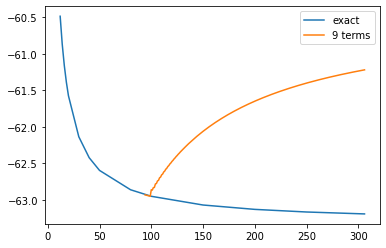

In [66]:
N = np.arange(start-6,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(x,exact_x100_m0/x, label = 'exact')
plt.plot(N,E9_x100_m0/N, label = '9 terms')
plt.legend()

### 11 terms

In [67]:
#m = 0, x = 100 Data from MPS
w001011 = 0.0088909404618675
w0011 = 0.0402435396148426
w01 = 0.415377161953834
w10 = 0.447126060915845
w10001011 = 0.00322667257534018
w100011 = 0.0142051984348521
w1001 = 0.151858299610668
w1010 = 0.219958993092895
w10110 = 0.0526053571953399
w1011100 = 0.0024767891571256
w110 = 0.0791951282297465
w11100 = 0.00278473729142628
print(n)
n = np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100 + w1011100 + w10001011)

0.9925317908689232


In [68]:
a= torch.zeros(16)
a[0] = np.sqrt(0.415388283972123)*np.sqrt(0.995304309795281**2	+0.0655118343657348**2)
a[1] = np.sqrt(0.447117693151699)*np.sqrt(0.991989652826353**2+	0.0652936606335732**2)
a[2] = np.sqrt(0.040247740846978)*np.sqrt(0.798085723689355**2 +	0.579642127523834**2)
a[3] = np.sqrt(0.0791851098619123)*np.sqrt(0.832499959069733**2	-0.438321017182823**2)
a[4] = np.sqrt(0.529937468823771)*np.sqrt(0.177079053942673**2 +	0.833025150964529**2)
a[5] = np.sqrt(0.415180104299204)*np.sqrt(0.687043825799479**2+	0.723131010084857**2)
a[6] = np.sqrt(0.415400781720677)*np.sqrt(0.766815850380277**2 + 0.637898431397149**2)
a[7] = np.sqrt(0.529553724140784)*np.sqrt(0.725822103954878**2 + 0.44536239129891**2)

a[8] = torch.clone(a[0])
a[9] = torch.clone(a[2])
a[10] = torch.clone(a[1])
a[11] = np.sqrt(0.00889267543568131)*np.sqrt(0.960407412916217**2+	0.182757202340431**2) # torch.clone(torch.tensor(np.sqrt(w001011)))
a[12] = np.sqrt(0.00278400026576385)*np.sqrt(0.587853079152462**2+	0.781519205174316**2)# torch.clone(torch.tensor(np.sqrt(w11100)))
a[13] = torch.clone(a[2])

a[14] = torch.clone(a[2])
a[15] = torch.clone(a[0])
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[8],a[9],a[10],a[11],a[12],a[13],a[14],a[15]])

In [69]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)

ol[12] = ol[12]*np.sqrt(w10001011*w100011)
ol[13] = ol[13]*np.sqrt(w10001011*w1001)
ol[14] = ol[14]*np.sqrt(w10110*w1011100)
ol[15] = ol[15]*np.sqrt(w01*w10001011)
ol[16] = ol[16]*np.sqrt(w01*w1011100)
ol[17] = ol[17]*np.sqrt(w1011100*w110)

ol[18] = ol[18]*np.sqrt(w001011*w01)
ol[19] =ol[19]*np.sqrt(w001011*w0011)

In [70]:
nq = 92
m = 0
E = []
for nq in np.arange(92,100):
  H_r = torch.zeros(4,4)
  H_r[0,0] = -63.29*nq + 227.1
  H_r[1,1] = -63.3*nq + 162.7
  H_r[2,2] = -63.3*nq + 162 
  H_r[3,3] = -63.34*nq + 217.4
  H_r[0,1] =  -71.01
  H_r[1,0] =  -71.01
  H_r[2,1] = -98.75
  H_r[1,2] = -98.75
  H_r[2,3] = -75.93
  H_r[3,2] = -75.93
  values, vectors = np.linalg.eig(H_r)
  R1 = vectors[:,0].reshape(-1)
  E.append(values[0])

start = 100
for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - start + 2] +5 +2*m) + w0011*(E[nq - start + 4] +3 + 2*m) + w01*( E[nq - (start- 6)] + 1 +2*m) + w100011*( E[nq - (start-2)] +3 +2*m) + w1001*( E[nq - (start-4)]+1 +2*m ) + w1010*( E[nq - (start-4)]) + w10110*( E[nq - (start-3)]+1+2*m ) + w110*(E[nq - (start-5)] + 1 +2*m)+ w11100*(E[nq - (start-3)]+ 3 +2*m)  + w1011100*(E[nq-start+1] + 3 + 2*m) + w10001011*(E[nq-start]+ 5 + 2*m))/n**2 + 200*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  E.append(E_)

In [71]:
np.savetxt('E11_x100_m0.txt',E)
E11_x100_m0 = np.loadtxt('E11_x100_m0.txt')

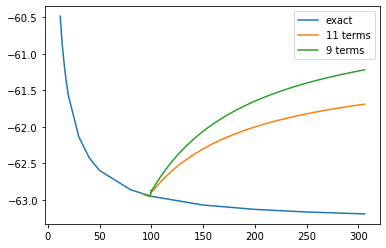

In [72]:
N = np.arange(start-8,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(x,exact_x100_m0/x, label = 'exact')
plt.plot(N,E11_x100_m0/N, label = '11 terms')
N = np.arange(start-6,307,1)
plt.plot(N,E9_x100_m0/N, label = '9 terms')
plt.legend()

## x = 100 m = 2.5

### 9 terms

In [73]:
#m = 2.5 x = 100 Data from MPS
ol = torch.tensor([])
w001011 = 0.00752988246523393
w0011 = 0.035863661035673
w01 = 0.3974
w10 = 0.4648
w100011 = 0.0127160651123813 
w1001 = 0.1485
w1010 = 0.236955371322187
w10110 = 0.0587275332441122
w110 =0.0861859006896203
w11100 = 0.0030668984636399
n = np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100)

In [74]:
a= torch.zeros(8)
a[0] = np.sqrt(0.397387637301697)*np.sqrt(0.956306426619269**2+	0.285148316775481**2)
a[1] = np.sqrt(0.464778802690724)*np.sqrt(0.952480645866461**2+	0.284007558007137**2)
a[2] = np.sqrt(0.0358644352731934)*np.sqrt(0.230161612579563**2+	0.960617063929095**2)
a[3] = np.sqrt(0.0861840043856103)*np.sqrt(0.964436759696804**2+0.0415491118902738**2)
a[4] = np.sqrt(0.55461568837445)*np.sqrt(0.882948072790023**2+	0.131401647715683**2)
a[5] = np.sqrt(0.397358513406266)*np.sqrt(	0.921277350849207**2+	0.383513868458209**2)
a[6] = np.sqrt(0.397390104164239)*np.sqrt(	0.500122086688256**2+	0.863544534257813**2)
a[7] = np.sqrt(0.554561386692807)*np.sqrt(	0.865634457842551**2+	0.218018828045557**2)
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[2],a[0]])

In [75]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)

ol[12] = ol[12]*np.sqrt(w001011*w01)
ol[13] = ol[13]*np.sqrt(w001011*w0011)

In [76]:
nq = 94
m = 2.5
E = []
for nq in np.arange(94,100):
  H_r = torch.zeros(4,4)
  H_r[0,0] = -62.15*nq + 216.9
  H_r[1,1] = -62.12*nq + 160
  H_r[2,2] = -62.12*nq + 165.6
  H_r[3,3] = -62.1*nq + 230.1
  H_r[0,1] =  -68.97
  H_r[1,0] =  -68.97
  H_r[2,1] = -98.81
  H_r[1,2] = -98.81
  H_r[2,3] = -77.66
  H_r[3,2] = -77.66
  values, vectors = np.linalg.eig(H_r)
  R1 = vectors[:,0].reshape(-1)
  E.append(values[0])


start = 100
for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - (start)] +5 +2*m) + w0011*(E[nq - (start-2)] +3 + 2*m) + w01*( E[nq - (start- 4)] + 1 +2*m) + w100011*( E[nq - (start)] +3 +2*m) + w1001*( E[nq - (start-2)]+1 +2*m ) + w1010*( E[nq - (start-2)]) + w10110*( E[nq - (start-1)]+1+2*m ) + w110*(E[nq - (start-3)] + 1 +2*m)+ w11100*(E[nq - (start-1)]+ 3 +2*m) )/n**2 + 200*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  #print(E_)
  E.append(E_)

In [77]:
np.savetxt('E9_x100_m25.txt',E)
E9_x100_m25 = np.loadtxt('E9_x100_m25.txt')

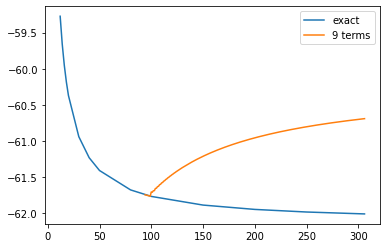

In [78]:
N = np.arange(start-6,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(x,exact_x100_m25/x, label = 'exact')
plt.plot(N,E9_x100_m25/N, label = '9 terms')
plt.legend()

###11 term

In [79]:
#m = 2.5 x = 100 Data from MPS
ol = torch.tensor([])
w001011 = 0.00752988246523393
w0011 = 0.035863661035673
w01 = 0.3974
w10 = 0.4648
w10001011 = 0.00272652745951234
w100011 = 0.0127160651123813 
w1001 = 0.1485
w1010 = 0.236955371322187
w10110 = 0.0587275332441122
w1011100 = 0.00276586246508559
w110 =0.0861859006896203
w11100 = 0.0030668984636399
n = np.sqrt(w001011+w0011+w01+w100011+w1001+w1010+w10110+w110+w11100 + w1011100 + w10001011)

In [80]:
a= torch.zeros(16)
a[0] = np.sqrt(0.397387637301697)*np.sqrt(0.956306426619269**2+	0.285148316775481**2)
a[1] = np.sqrt(0.464778802690724)*np.sqrt(0.952480645866461**2+	0.284007558007137**2)
a[2] = np.sqrt(0.0358644352731934)*np.sqrt(0.230161612579563**2+	0.960617063929095**2)
a[3] = np.sqrt(0.0861840043856103)*np.sqrt(0.964436759696804**2+0.0415491118902738**2)
a[4] = np.sqrt(0.55461568837445)*np.sqrt(0.882948072790023**2+	0.131401647715683**2)
a[5] = np.sqrt(0.397358513406266)*np.sqrt(	0.921277350849207**2+	0.383513868458209**2)
a[6] = np.sqrt(0.397390104164239)*np.sqrt(	0.500122086688256**2+	0.863544534257813**2)
a[7] = np.sqrt(0.554561386692807)*np.sqrt(	0.865634457842551**2+	0.218018828045557**2)
a[8] = torch.clone(a[0])
a[9] = torch.clone(a[2])
a[10] = torch.clone(a[1])
a[11] = np.sqrt(0.00753020024562515)*np.sqrt(0.742989840069015**2	+0.63835919307174**2) # torch.clone(torch.tensor(np.sqrt(w001011)))
a[12] = np.sqrt(0.00306675615032512)*np.sqrt(0.189675996965461**2+	0.971104086381543**2) #torch.clone(torch.tensor(np.sqrt(w11100)))
a[13] = torch.clone(a[2])
a[14] = torch.clone(a[2])
a[15] = torch.clone(a[0])
ol = torch.tensor([a[0], a[2],a[0],a[1],a[3],a[6],a[7],a[4],a[5],a[6],a[2], a[5],a[8],a[9],a[10],a[11],a[12],a[13],a[14],a[15]])

In [81]:
ol[0] = ol[0]*np.sqrt(w0011*w01)
ol[1] = ol[1]*np.sqrt(w01*w100011)
ol[2] = ol[2]*np.sqrt(w1001*w01)
ol[3] = ol[3]*np.sqrt(w01*w1010)
ol[4] = ol[4]*np.sqrt(w01*w10110)
ol[5] = ol[5]*np.sqrt(w1001*w100011)
ol[6] = ol[6]*np.sqrt(w1010*w10110)
ol[7] = ol[7]*np.sqrt(w110*w1010)
ol[8] = ol[8]*np.sqrt(w110*w10110)
ol[9] = ol[9]*np.sqrt(w001011*w0011)
ol[10] = ol[10]*np.sqrt(w001011*w01)
ol[11] = ol[11]*np.sqrt(w11100*w110)
ol[12] = ol[12]*np.sqrt(w10001011*w100011)
ol[13] = ol[13]*np.sqrt(w10001011*w1001)
ol[14] = ol[14]*np.sqrt(w10110*w1011100)
ol[15] = ol[15]*np.sqrt(w01*w10001011)
ol[16] = ol[16]*np.sqrt(w01*w1011100)
ol[17] = ol[17]*np.sqrt(w1011100*w110)
ol[18] = ol[18]*np.sqrt(w001011*w01)
ol[19] =ol[19]*np.sqrt(w001011*w0011)


In [82]:
nq = 92
m = 2.5
E = []
for nq in np.arange(92,100):
  H_r = torch.zeros(4,4)
  H_r[0,0] = -62.15*nq + 216.9
  H_r[1,1] = -62.12*nq + 160
  H_r[2,2] = -62.12*nq + 165.6
  H_r[3,3] = -62.1*nq + 230.1
  H_r[0,1] =  -68.97
  H_r[1,0] =  -68.97
  H_r[2,1] = -98.81
  H_r[1,2] = -98.81
  H_r[2,3] = -77.66
  H_r[3,2] = -77.66
  values, vectors = np.linalg.eig(H_r)
  R1 = vectors[:,0].reshape(-1)
  E.append(values[0])

start = 100
for nq in np.arange(start,307,1):
  E_ = (w001011*( E[nq - start + 2] +5 +2*m) + w0011*(E[nq - start + 4] +3 + 2*m) + w01*( E[nq - (start- 6)] + 1 +2*m) + w100011*( E[nq - (start-2)] +3 +2*m) + w1001*( E[nq - (start-4)]+1 +2*m ) + w1010*( E[nq - (start-4)]) + w10110*( E[nq - (start-3)]+1+2*m ) + w110*(E[nq - (start-5)] + 1 +2*m)+ w11100*(E[nq - (start-3)]+ 3 +2*m)  + w1011100*(E[nq-start+1] + 3 + 2*m) + w10001011*(E[nq-start]+ 5 + 2*m))/n**2 + 200*(-ol.sum()-np.sqrt(w1010*w1001))/n**2
  E.append(E_)

In [83]:
np.savetxt('E11_x100_m25.txt',E)
E11_x100_m25 = np.loadtxt('E11_x100_m25.txt')

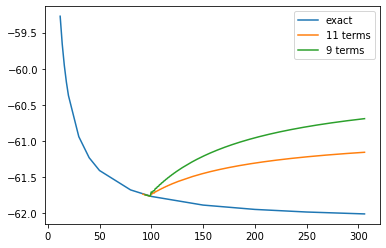

In [84]:
N = np.arange(start-8,307,1)
x = torch.tensor([12,14,16,18,20,30,40,50,80,100,150,200,250,306])
plt.plot(x,exact_x100_m25/x, label = 'exact')
plt.plot(N,E11_x100_m25/N, label = '11 terms')
N = np.arange(start-6,307,1)
plt.plot(N,E9_x100_m25/N, label = '9 terms')
plt.legend()

#Res

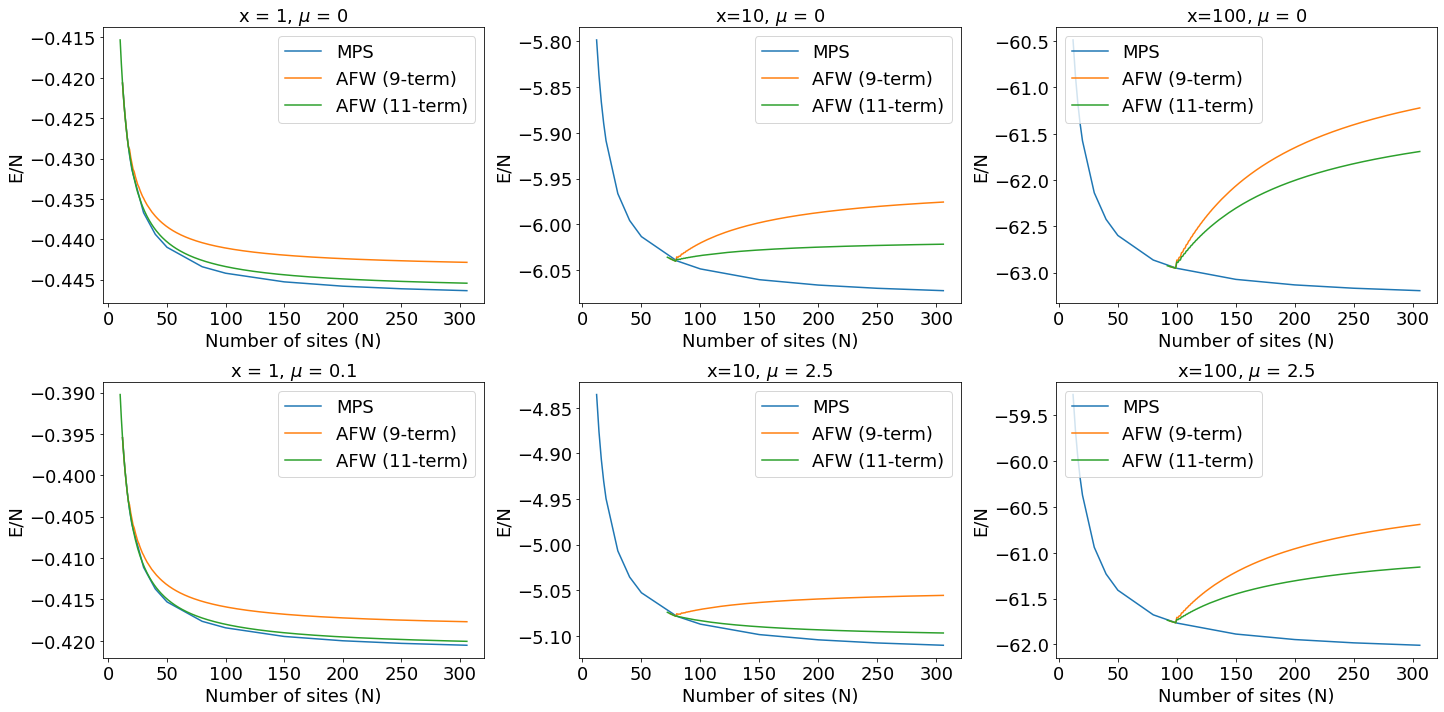

In [86]:
fig,ax = plt.subplots(2,3,figsize = (20,10))
size = 18

ax[0,0].plot(x,exact_x1_m0/x, label = 'MPS')
N = np.arange(18-6,307,1)
ax[0,0].plot(N,E9_x1_m0/N, label = 'AFW (9-term)')
N = np.arange(18-8,307,1)
ax[0,0].plot(N,E11_x1_m0/N, label = 'AFW (11-term)')
# t = torch.arange(8,308)
# ax[0,0].plot(t,mari9_x1_m0_nq307, label = 'AD (6-term)')
# t = torch.arange(10,307)
# ax[0,0].plot(t,mari11_x1_m0_nq306, label = 'AD (11-term)')
ax[0,0].legend(fontsize=size)

ax[0,0].set_title('x = 1, $\mu$ = 0', fontsize=size)

N = np.arange(18-6,307,1)
ax[1,0].plot(x,exact_x1_m01/x, label = 'MPS')
ax[1,0].plot(N,E9_x1_m01/N, label = 'AFW (9-term)')
N = np.arange(18-8,307,1)
ax[1,0].plot(N,E11_x1_m01/N, label = 'AFW (11-term)')
# t = torch.arange(8,307)
# ax[1,0].plot(t,mari9_x1_m01_nq306, label = 'AD (6-term)')
# t = torch.arange(10,307)
# ax[1,0].plot(t,mari11_x1_m01_nq306, label = 'AD (11-term)')
ax[1,0].legend(fontsize=size)
ax[1,0].set_title('x = 1, $\mu$ = 0.1', fontsize=size)

t = torch.arange(8,307)
ax[0,1].plot(x,exact_x10_m0/x, label = 'MPS')
N = np.arange(74,307,1)
ax[0,1].plot(N,E9_x10_m0/N, label = 'AFW (9-term)')
N = np.arange(80-8,307,1)
ax[0,1].plot(N,E11_x10_m0/N,label = 'AFW (11-term)')
# ax[0,1].plot(t, mari9_x10_m0_nq306, label = 'AD (6-term)' )
# t = torch.arange(10,307)
# ax[0,1].plot(t, mari11_x10_m0_nq306,label = 'AD (11-term)' )
ax[0,1].set_title('x=10, $\mu$ = 0',fontsize=size)
ax[0,1].legend(fontsize=size)

t = torch.arange(8,307)
ax[1,1].plot(x,exact_x10_m25/x, label = 'MPS')
N = np.arange(74,307,1)
ax[1,1].plot(N,E9_x10_m25/N, label = 'AFW (9-term)')
N = np.arange(80-8,307,1)
ax[1,1].plot(N,E11_x10_m25/N,label = 'AFW (11-term)')
# ax[1,1].plot(t, mari9_x10_m25_nq306, label = 'AD (6-term)' )
# t = torch.arange(10,307)
# ax[1,1].plot(t, mari11_x10_m25_nq306, label = 'AD (11-term)' )
ax[1,1].set_title('x=10, $\mu$ = 2.5', fontsize=size)
ax[1,1].legend(fontsize=size)


ax[0,2].plot(x,exact_x100_m0/x, label = 'MPS')
#N = np.arange(100-6,1000,1)
N = torch.arange(100-6,307,1)
ax[0,2].plot(N,E9_x100_m0[:307-100+6]/N,label = 'AFW (9-term)')
#N = np.arange(100-8,1000,1)
N = np.arange(100-8,307,1)
ax[0,2].plot(N,E11_x100_m0[:307-100+8]/N,label = 'AFW (11-term)')
# t = torch.arange(8,307)
# #t = torch.arange(8,1001)
# ax[0,2].plot(t, mari9_x100_m0_nq1000[:307-8], label = 'AD (6-term)' )
# # t = torch.arange(10,1001)
# t = torch.arange(10,307)
# ax[0,2].plot(t, mari11_x100_m0_nq1000[:307-10],label = 'AD (11-term)' )
ax[0,2].set_title('x=100, $\mu$ = 0', fontsize=size)
ax[0,2].legend(fontsize=size, loc = 'upper left')


ax[1,2].plot(x,exact_x100_m25/x, label = 'MPS')
#N = np.arange(100-6,1000,1)
N = torch.arange(100-6,307,1)
ax[1,2].plot(N,E9_x100_m25[:307-100+6]/N,label = 'AFW (9-term)')
#N = np.arange(100-8,1000,1)
N = np.arange(100-8,307,1)
ax[1,2].plot(N,E11_x100_m25[:307-100+8]/N,label = 'AFW (11-term)')
# t = torch.arange(8,307)
# #t = torch.arange(8,1001)
# ax[1,2].plot(t, mari9_x100_m25_nq1000[:307-8], label = 'AD(6-term)' )
# # t = torch.arange(10,1001)
# t = torch.arange(10,307)
# ax[1,2].plot(t, mari11_x100_m25_nq1000[:307-10], label = 'AD (11-term)' )
ax[1,2].set_title('x=100, $\mu$ = 2.5', fontsize=size)
ax[1,2].legend(fontsize=size, loc = 'upper left' )
for i in range(2):
  for j in range(3):
    ax[i,j].set_xlabel('Number of sites (N)',  fontsize=size)
    ax[i,j].set_ylabel('E/N',  fontsize=size)
    ax[i,j].tick_params(labelsize = size)
fig.tight_layout()
# fig.savefig('gr.pdf', dpi=500)
# fig.savefig('gr.png', dpi=500)
